# SPNC rundown
*This is a rundown of thoughts and ideas for the SPNC (Superparamagnetic neuromorphic computing) project*

Notation: <br>
$\beta = 1/k_BT$ <br>
$w$ is transition rate <br>
$H_K = 2K/M_s $

Some useful references: <br>
Theory of ferromagnetism, Aharoni [ISBN: 0198508093](http://books.google.com/books?vid=ISBN0198508093)

***

## State of play
*Items in **bold** are important for a paper.*

**Questions we've answered:**
- Voltage control is possible
- We can do NARMA10 task (similar to Appeltant) with field and voltage

**Questions we're working on:**
- **What does a practical device look like? There are important questions about timescales and errors.**
- **Heat maps (with scaling factor and offset to input) at different $\beta'$**
- **Speech recognition task**
- Multiple resevoirs
- How does the mask effect ML? 
- What role does number of virtual nodes play? (This is related to mask, but also feedback).
- What is the role of feedback?

**Questions we're interested in considering:**
- How can we quantify non-linearity of res (or input function)? How does this work with generic resevoirs?
- What is the effect of oscilatory inputs?
- Bring in micromagnetics

## Outlook

- Want to publish simulation paper with suggestion of sensible device
- Use this as basis for grant application and to drive experiments

***

## A model system

First we need a model of the behaviour of a superparamagnetic ensemble.
If this shows non-linearity and memory, it can be interfaced into a machine learning code. <br>
([1](http://dx.doi.org/10.1063/1.3477956)) Chantrell, Walmsley, Gore and Maylin - **Model system** for interacting superparamagnetic particles showing strong non-linearity dependant on packing density. *Many links to other papers* <br>
([2](http://dx.doi.org/10.1103/PhysRevB.63.024410)) Hovorka, Evans, Chantrell and Berger - A follow up to the above, looking at switching fields  and sweep rate dependance. <br>

From (1): <br>
We get a relaxation time/transition rate, $w = \tau^{-1} = f_0 \exp{(-E_b \beta)}$ where $f_0$ is typically taken between $10^9$ &ndash; $10^{11}$ s$^{-1}$ (strictly it is a very slowly changing variable, but this can typically be ignored)<br>
To begin with we will consider $KV \gg \beta^{-1}$ as this approximates to a simple two state system&mdash;otherwise something like the Metropolis algorith is required to take into account the local moves near the minima. We can then describe the system using the master equation for a two-state system: <br>
$$ \frac{dn_1}{dt} = \frac{n_2}{\tau_{21}} - \frac{n_1}{\tau_{12}} $$ <br>
- Given that $ n = n_1 + n_2 $ and $ M = M_s v (n_1 - n_2)$ $\implies M = Ms V (2 n_1 - n)$ <br>
- This approach works well for $ E_b \geq 3 \beta^{-1} $ <br>
Taking the field along the anisotropy axis, in direction such that state 1 is the minima for positive field and using $H_k = 2K/M_s$:
$$ E_{21} = KV( 1 - H/H_K)^2$$ and $$ E_{12} = KV( 1 + H/H_K)^2 $$
Therefore we can rewrite the master equation as:
$$ \frac{dn_1}{dt} = f_0 (n - n_1) \exp{(-\beta KV(1-H/H_k)^2)} - f_0 n_1 \exp{(-\beta KV(1+H/H_k)^2)} $$ <br>


In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np

# Remove previously opened figure
if 'fig' in locals():
    plt.close(fig)

# Basic energy for 1D model with H along the anisotropy axis
def basic_energy(K,V,muH,theta):
    energy = K*V*np.power(np.sin(theta*np.pi/180),2) - muH * np.cos(theta*np.pi/180)
    return energy

# Make a schematic plot for the energy
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks([])
    plt.yticks([])
    plt.title('Energy landscape schematic')

    theta = np.arange(-30,210,1)
    ax.set_xlim([-30, 210])
    plt.plot(theta,basic_energy(1,1,0.25,theta))

    ax.annotate('minima one',xy=(0,basic_energy(1,1,0.25,0)),arrowprops=dict(arrowstyle='->'),xytext=(10,.75))
    ax.annotate('minima two',xy=(180,basic_energy(1,1,0.25,180)),arrowprops=dict(arrowstyle='->'),xytext=(180,.75))
    ax.annotate('KT << delta E',xy=(0,basic_energy(1,1,0.25,180)),xytext=(70,.35))

    plt.xlabel('theta')
    plt.ylabel('energy')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Comparison to mumax model so far

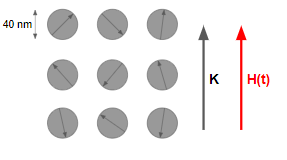

In [2]:
from IPython.display import Image
Image(filename="images/basic-system-schematic.png")

### Tom's model

From intuition, the form under constant field/decay should be given by:

**Decay:**
$$ \frac{M}{M_s} = e^{-t/\tau} $$
**Excitation:**
$$ \frac{M}{M_s} = a(H)\left( 1 - e^{-t/b(H)} \right) $$

### The new description

***NB: I have had to change the order of ij relative to the papers, as there was a mistake!*** <br>
From (2) and (1) we can recast the master equation given above, via integration, to find the probability of occupation of either state at a time t (given constant H):
$$ p_i(t) =  \frac{w_{ji}}{w} + \left[p_i(0) - \frac{w_{ji}}{w} \right] \exp{(-wt)} $$
where $w = w_{12} + w_{21}$. As $ m = M/M_s n V = (P_1 - P_2) $ we get:
$$ m(t) = \left( \frac{w_{21} - w_{12}}{w} \right) + \left[ m(0) - \left( \frac{w_{21} - w_{12}}{w} \right) \right] \exp{(-wt)} $$
For $w_{12} = w_{21}$ (i.e. no field), this reduces to the decay term:
$$ m(t) = m(0) \exp{(-wt)} $$
For constant field and m(0) = 0, this reduces to the excitation term:
$$ m(t) = \left( \frac{w_{21} - w_{12}}{w} \right) [1 - \exp{(-wt)}] $$
NB: $w$ is field dependant, so it is *different* in these two cases!! <br>
We can therefore link a(H) and b(H) to transition rates, or likewise calculate transition rates from a(H) and b(H).
$$ a(H) = n V\left( \frac{w_{21} - w_{12}}{w} \right) =  nV \frac{e^{HM_sV\beta} - e^{-HM_sV\beta}}{e^{HM_sV\beta} + e^{-HM_sV\beta}} = nV \tanh{\left( \frac{HM_sV}{K_B T} \right)} $$
$$ 1/b(H) = w = f_0 \exp{(-\beta KV(1-H/H_k)^2)} + f_0 \exp{(-\beta KV(1+H/H_k)^2)} $$
Where the derivation following the second equals signs is for the stoner-wolfarth case. <br>
This lets us feed our mumax simulations back into a solver with the equation:
$$ \frac{dn_1}{dt} = w_{21}(H,T){n_2} - w_{12}(H,T){n_1} $$ <br>

## The stoner-wolfarth model: simplifications for modelling

In the case of the SW model, it is worth simplifying the expressions by looking at relative energies and fields; the real units are not so important here, rather the behaviour.
Let us denote $w_{21} = w_+ \, \& \, w_{12} = w_-$ and rewrite the transition rates as follows:

$$ w_{\pm} = f_0 \exp{ \left( - (KV/K_B T) (1 \mp H/H_K)^2 \right) } $$

Then taking $\beta' = KV/K_BT$ and $H' = H/H_K$ and setting (without loss of generality) $f_0 = 1$, we can write:

$$ w_{\pm} = \exp{(-\beta' (1 \mp H')^2)} $$
where we see from our condition $E_b \beta \ge 3$ that at minimum $\beta' \ge 3$ and $ |H'| < 1$. The second condition is also apparent as the higher energy state will no longer be a minimum once $H > H_K$ which breaks our two state model. <br>

We see that the important features are a thermal energy like term and a field like term - although of course they are dimensionless here! We can also more generically absorb our constant $f_0$ into the time parameter to get the dimensionless, $t' = tf_0$. Taking also that $n'_1 = n_1/n \, \, \& \, \, n'_2 = n_2 /n$, allows us to write:

$$ dn'_1 / dt' =  (1-n'_1) \exp{(-\beta' (1 - H')^2)} - n'_1 \exp{(-\beta' (1 + H')^2)}  $$
For the integrated description, we find that:
$$ \frac{w_+ - w_-}{w} = \frac{e^{2\beta' H'} - e^{-2\beta' H'}}{e^{2\beta' H'} + e^{-2\beta' H'}} = \tanh{(2\beta' H')} $$
and:
$$ w = 2 \cosh{(2\beta' H')} \exp{(-\beta' (1+H'^2))} $$
Such that:
$$ m(t') = \tanh{(2\beta' H')} + [m(0) - \tanh{(2\beta' H')}] \exp{\left( - w t' \right)} $$
Which we can rearrange to:
$$ m(t') = \tanh{(2\beta' H')} \left[ 1 - \exp{\left( - w t' \right)} \right] + m(0) \exp{\left( - w t' \right)} $$

We have two terms, an exciation and a decay, both with the same characteristic time scale. The decay represents loss of memory of the start state. The excitation represents response to the new input. Note, however, that for changing fields, the excitation to a value under one field and the decay away from it at another *do not* have the same time scale.

### Characteristic timescale

This model works well as our basic case for ML, but it would be good to put time in reference to some charactersitic time scale. This means that in our resevoirs we don't need to worry about how changing $\beta$ changes time over which the basic (no field) decay happens.
$$ w(H'=0) = w_0 = 2 \exp{(-\beta')} $$
$$ \implies wt' = \frac{w}{w_0} [w_0 t'] = \cosh{(2 \beta' H')} \exp{(-\beta' H'^2)} [w_0 t'] = w' [w_0 t']$$
This rearangment allows us to look at our time in units of $w_0$ and consider changes in rate with field via:
$$ w' = \cosh{(2 \beta' H')} \exp{(-\beta' H'^2)} $$

This gives us two advantages:
1) We can reference timescales in our model to our base rate $w_o t'$. We won't have to worry about updating the timesteps between virtual nodes when we change $\beta'$ for example. <br>
2) If we use $w_0t'$ as time, then we can see that one key effect of changing $\beta'$ is to change the sensitivity of the rate with field. We can examine $w'$ in more detail to see what this looks like. 

**This also has an important implication:**
Because running at different $\beta'$ changes the sensitivity to field, *we can not simply scale the time period as we scale $\beta'$ and get the same results*. This has implications for devices&mdash;*Size matters!*.

Let's examine $w'$ in more detail:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

#3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# Remove previously open figure
if 'w_prime_fig' in locals():
    plt.close(w_prime_fig)

# Function that defines w_prime
def w_prime(beta_prime,h_prime):
    w_prime = np.cosh(2*beta_prime*h_prime)*np.exp(-beta_prime*np.power(h_prime,2))
            
    return w_prime

# Set up plot
w_prime_fig = plt.figure()
ax = w_prime_fig.gca(projection='3d')
beta_prime = np.arange(3,30,.1)
h_prime = np.arange(-1,1,0.05)
beta_prime, h_prime = np.meshgrid(beta_prime, h_prime)
ax.set_title('Sensitivity of rate to field')
ax.set_xlabel("beta_prime")
ax.set_ylabel('h_prime')
ax.set_zlabel('log(base rate multiplier)')
ax.view_init(azim=133, elev=45)
# Plot
surf = ax.plot_surface(beta_prime,h_prime,np.log(w_prime(beta_prime,h_prime)), cmap = cm.coolwarm,
                      linewidth = 0, antialiased=False)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now lets look at the absolute rate $w$:

In [4]:
# Remove previously open figure
if 'w_prime_fig' in locals():
    plt.close(w_prime_fig)

# Function that defines w_prime
def w_absolute(beta_prime,h_prime):
    w_absolute = 2*np.cosh(2*beta_prime*h_prime)*np.exp( -beta_prime * ( 1+np.power(h_prime,2) ) )
            
    return w_absolute
    

# Set up plot
w_prime_fig = plt.figure()
ax = w_prime_fig.gca(projection='3d')
beta_prime = np.arange(3,30,.1)
h_prime = np.arange(-1,1,0.05)
beta_prime, h_prime = np.meshgrid(beta_prime, h_prime)
ax.set_title("Absolute rate")
ax.set_xlabel("beta_prime")
ax.set_ylabel('h_prime')
ax.set_zlabel('log(rate)')
ax.view_init(azim=133, elev=45)
# Plot
surf = ax.plot_surface(beta_prime,h_prime,np.log(w_absolute(beta_prime,h_prime)), 
                       cmap = cm.coolwarm, linewidth = 0, antialiased=False)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

As we go to higher values of $\beta'$, this dramatic change in field sensitivity may cause us problems with our machine learning problems as close variables will end up getting very highly seperated! Let's therefore consider some useful ranges of $\beta'$. For practical measurments in our lab we may want a base rate that operates in seconds. We want the time for a change in the input of $e^{-1}$:

In [5]:
def beta_finder(t, f0):
    beta_prime = -np.log(1/(t*2*f0))
    return beta_prime

def time_finder(beta_prime,f0):
    time = 1/(2*f0*np.exp(-beta_prime))
    return time

print('Assuming f0 = 10^10')
print('beta for measurment in seconds is ', beta_finder(1,10**10))
print('time for a beta_prime of 3 is ', time_finder(3,10**10), 'seconds')

Assuming f0 = 10^10
beta for measurment in seconds is  23.7189981105004
time for a beta_prime of 3 is  1.0042768461593833e-09 seconds


This means we can limit our exploration to values of $3 < \beta' < 30$ which helps! This gives a time base from seconds (for easy lab work) down to nano seconds (for a real device).

### An alternative viewpoint: anisotropy control

Above, we considered manipulating the system via an effective temperature and field. However, these may not, in general, be the parameters we wish to change. If we envisage a fixed (non-zero) field and a changeable anisotropy (e.g. via strain) we can condsider whether it is possible to manipulate $m(t')$. Let us consider first turning on the field. For the next time step then, $m(0) = {(w_+ - w_-)}/{w}$. In our standard case, this is independant of anisotropy - $\tanh{(HM_s V/K_B T)}$. We can examine this more closely by writing:  <br>
$$ \frac{w_+ - w_-}{w} = \frac{ f_0 \exp{(-E_+ \beta)} - f_0 \exp{(-E_- \beta)} }{ f_0 \exp{(-E_+ \beta)} + f_0 \exp{(-E_- \beta)} } $$
Adjusting the anisotropy is akin to $ E_- \rightarrow E_- + \Delta E \, \, \&  \,\, E_+ \rightarrow E_+ + \Delta E$. 
$$ \implies \frac{w_+ - w_-}{w} \rightarrow \frac{ \left[ f_0 \exp{(-E_+ \beta)} - f_0 \exp{(-E_- \beta)} \right] \exp{(-\Delta E \beta)}  }{ \left[ f_0 \exp{(-E_+ \beta)} + f_0 \exp{(-E_- \beta)} \right] \exp{(-\Delta E \beta)} } = \frac{w_+ - w_-}{w} $$

What we need to achieve is the two energy barriers changing *differently*. One way to do that, is by rotating the anisotropy away from the field&mdash;for example with a non-collinear strain. This is easily shown with a demonstration:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Remove previously open figure
if 'figure' in locals():
    plt.close(figure)

# Basic energy for 1D model with H along the anisotropy axis (per unit volume)
def basic_energy(theta,K,Ks,alpha,muHMs,gamma):
    energy = (K*np.power(np.sin(theta*np.pi/180),2) + 
              Ks*np.power(np.sin((theta-alpha)*np.pi/180),2) 
              - muHMs * np.cos((theta-gamma)*np.pi/180)
             )
    return energy

figure, ax = plt.subplots()
'''
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
'''
ax.set_title('Energy landscape')
ax.set_xlabel('Angle of M to easy axis / deg')
ax.set_ylabel('Energy / AU')

theta = np.arange(-180,180,1)
ax.set_xlim([-180, 180])
#ax.plot(theta, basic_energy(1, 1, 0.25, theta), color='C0')

@widgets.interact(K=(0, 10, 0.1), Ks=(-10, 10, 0.1), 
                  alpha=(0, 90, 5), muHMs=(0, 20, 0.1), gamma=(0, 90, 5)
                 )
def update(K = 5, Ks = 0.0, alpha = 0, muHMs=0.0, gamma = 0.0):
    #Remove old lines from plot and plot new one
    [l.remove() for l in ax.lines]
    #Plot
    ax.plot(theta, basic_energy(theta,K,Ks,alpha,muHMs,gamma), color='C0')
    #Rescale axes
    ax.relim()
    ax.autoscale_view()
    



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=5.0, description='K', max=10.0), FloatSlider(value=0.0, description='K…

This shows the energy landscape for a single layer with intrinsic strain (K), Additional strain anisotropy (Ks) at an angle (alpha), and field (muHMs) at an angle (gamma). Our x axis is angle of the magnetisation $\implies -180^{\circ} = 180^{\circ}$. <br>
Try introducing a strain anisotropy and playing with its angle under a fixed field. It's clear that the two energy barriers are changing differently.

This is explored in detail in the SPNC-anisotropy notebook